### AIM:

We would like to see how efficient GPR is when trying to reconstruct 2d surface (not a dynamical system). We have already seen its effectiveness when applying it to a 1d (as given in the example of scilearn) case. Even for a 1d dynamical system (the example we considered in the earlier folders).

Lets consider a 2d surface ( that we would like to reconstruct) as given by the following equation. 
$$x_3=2*(sin(\frac{x_1}{2})cos(\frac{x_2}{2}))+3$$

### Plotting our function 

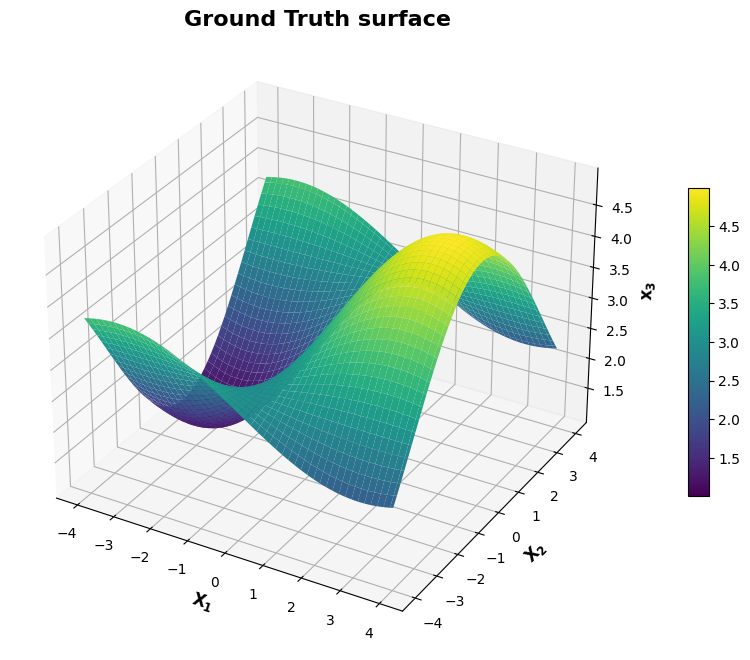

In [47]:
import numpy as np
import matplotlib.pyplot as plt

# defining our fucntion 
def my_func(x1,x2):
    x3 = 2*(np.sin(x1/2)*np.cos(x2/2))+3
    return x3

# plotting the function
##collecting data for plotting
x1 = np.linspace(-4,4,100)
x2 = np.linspace(-4,4,100)

x1,x2 = np.meshgrid(x1, x2)

x3 = my_func(x1,x2)

#plot
fig = plt.figure(figsize=(16,8))
axs = fig.add_subplot(111,projection="3d")

axs.set_title("Ground Truth surface", fontweight="bold",fontsize=16)
axs.set_xlabel("$\mathbf{X_1}$",fontsize=12)
axs.set_ylabel("$\mathbf{X_2}$",fontsize=12)
axs.set_zlabel("$\mathbf{x_3}$",fontsize=12)

ground_truth = axs.plot_surface(x1,x2,x3,cmap="viridis")
fig.colorbar(ground_truth,aspect=15,shrink=0.5)
#axs.view_init(elev=30,azim=30)

### Deciding on the training data
We will consider a grid of points to train our Gaussian. Let the grid size be nx * ny = 5 * 5. The ground truth has an x length of 8, y length of 8. For data let us consider the x length (lx) as 6 and y length (ly) as 4. 

In [48]:
nx = 5
ny = 5

lx = 6
ly = 4

x1_train = np.linspace(-lx/2,lx/2,5)
x2_train = np.linspace(-ly/2,ly/2,5)

x1_train,x2_train = np.meshgrid(x1_train,x2_train)
x1_train = x1_train.reshape(1,-1)
x2_train = x2_train.reshape(1,-1)
x_train = np.vstack([x1_train,x2_train])
x_train = np.transpose(x_train)
x3_train = my_func(x_train[:,0],x_train[:,1])


Plot of the training data on the ground truth surface.

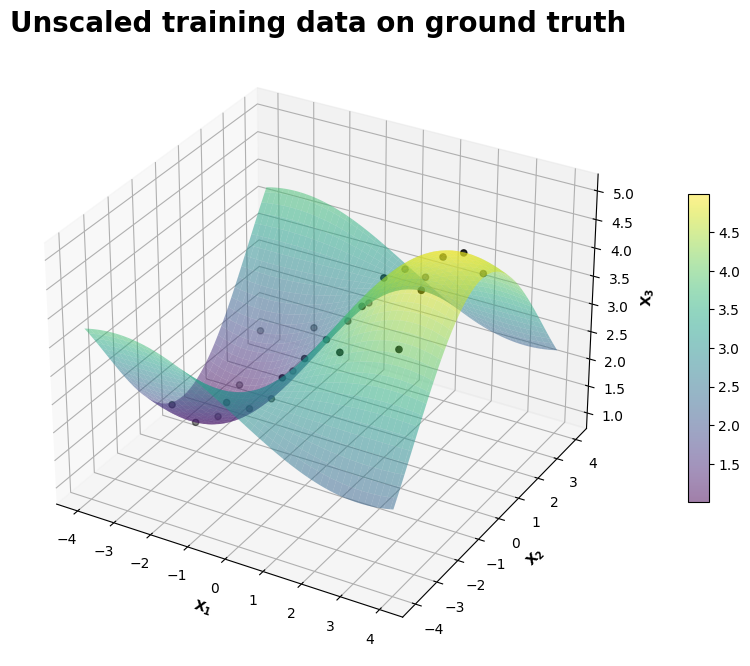

In [49]:
fig = plt.figure(figsize=(16,8))
axs = fig.add_subplot(111,projection="3d")

axs.set_title("Unscaled training data on ground truth",fontweight="bold", fontsize=20)
axs.set_xlabel("$\mathbf{X_1}$",fontweight=12)
axs.set_ylabel("$\mathbf{X_2}$",fontweight=12)
axs.set_zlabel("$\mathbf{X_3}$", fontweight=12)

ground_truth = axs.plot_surface(x1,x2,x3,cmap="viridis",alpha=0.5)
unscale_training = axs.scatter(x_train[:,0],x_train[:,1],x3_train,c="k")

fig.colorbar(ground_truth, shrink=0.5, aspect=15)
plt.show()

### Scaling the input data:
As Nunzia suggested the input data needs to be scaled. we only scale the input and not the output.

When we want to predict $x_3$ for given x, we need to rescale x then put it in gpr and find $x_3$. 

In [50]:
#importing the scaling libraries
from sklearn.preprocessing import MinMaxScaler

# defining an object in the MinMaxScaler() class.
scaler = MinMaxScaler()

# The input must me a 2d array for the min max scaler.
# our x_train is already a 2d.

#lets call the fit method
scaler.fit(x_train)

# given any data, now we can scale it based on the minimum and the maximum values calculated 
x_scaled_train = scaler.transform(x_train)

Lets plot the scaled input against unscaled $x_3$

In [51]:
# scaling the data to plot the scaled ground truth surface.
x1_shape=x1.shape
x2_shape = x2.shape

# note that x1_shape and x2_shape are the same. Writing here just for consisteny
x1_scaled = x1.reshape(1,-1)
x2_scaled = x2.reshape(1,-1)
x_scaled = np.vstack([x1_scaled,x1_scaled])
x_scaled = np.transpose(x_scaled)

# the scaling step
x_scaled = scaler.transform(x_scaled)

#reverting back to the mesh
#x = np.transpose(x)
x1_scaled = x_scaled[:,0]
x1_scaled = x1_scaled.reshape(x1_shape)

x2_scaled = x[:,1]
x2_scaled = x2_scaled.reshape(x2_shape)

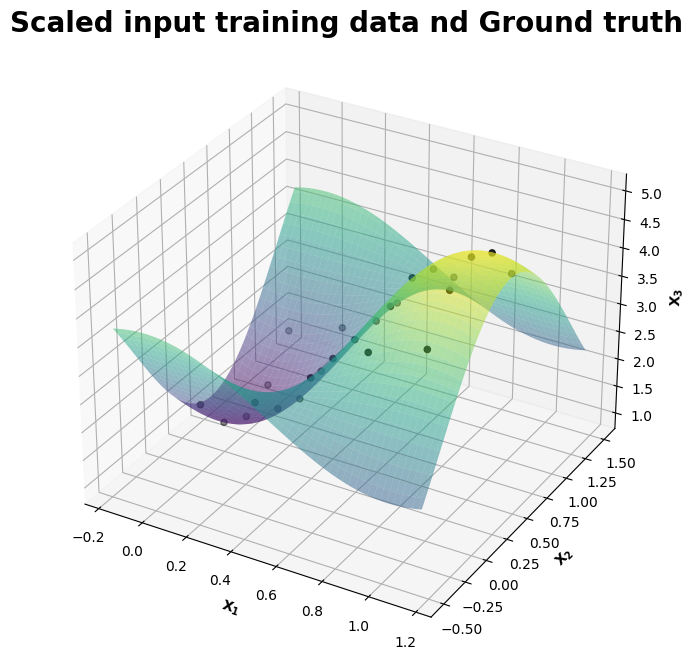

In [52]:
#Plotting the scaled input
fig = plt.figure(figsize=(16,8))
axs = fig.add_subplot(111,projection="3d")

axs.set_title("Scaled input training data nd Ground truth", fontsize=20, fontweight="bold")
axs.set_xlabel("$\mathbf{X_1}$",fontweight=12)
axs.set_ylabel("$\mathbf{X_2}$",fontweight=12)
axs.set_zlabel("$\mathbf{X_3}$", fontweight=12)

scaled_training = axs.scatter(x_scaled_train[:,0],x_scaled_train[:,1],x3_train,c="k")
ground_truth_scaled = axs.plot_surface(x1_scaled,x2_scaled,x3,cmap="viridis",alpha=0.5)
#axs.view_init(elev=0, azim=20)
plt.show()

Let us start learning the GPR using sklearn.

In [76]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
Ls=[1,1]
kernel = RBF(length_scale=np.array([1.0,1.0]), length_scale_bounds=(1e-5, 1e5))
gp = GaussianProcessRegressor(kernel=kernel,n_restarts_optimizer=100,random_state=15)
gp.max_iter_predict = 1000
gp.fit(x_scaled_train, x3_train)

GaussianProcessRegressor(kernel=RBF(length_scale=[1, 1]),
                         n_restarts_optimizer=100, random_state=15)

In [77]:
gp.kernel_

RBF(length_scale=[0.569, 0.73])

In [78]:
x1_test = x1.reshape(1,-1)
x2_test = x2.reshape(1,-1)

x_test = np.vstack([x1_test, x2_test])
x_test= np.transpose(x_test)
x_test_scaled = scaler.transform(x_test)

In [79]:

x3_gpr = gp.predict(x_test_scaled)
x3_gpr_2 = gp.predict(x_scaled_train)

### Prediction plots at different viewing angles

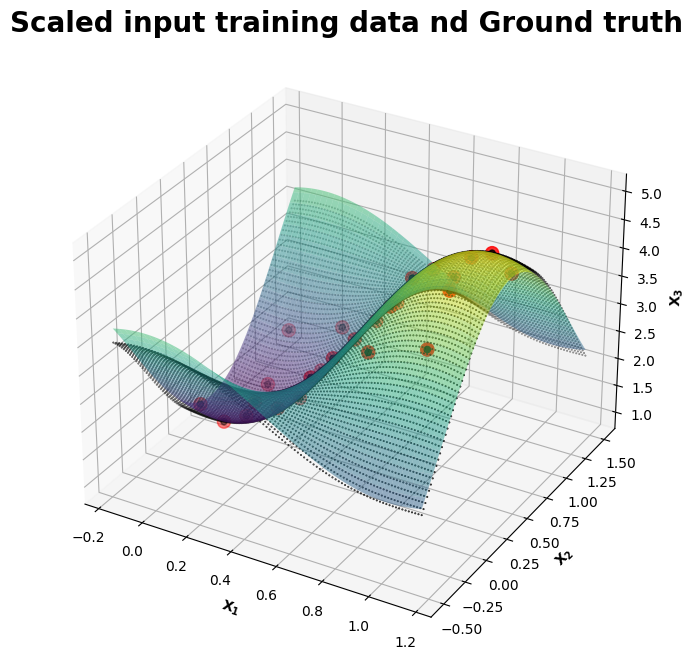

In [80]:
#Plotting the scaled input
fig = plt.figure(figsize=(16,8))
axs = fig.add_subplot(111,projection="3d")

axs.set_title("Scaled input training data nd Ground truth", fontsize=20, fontweight="bold")
axs.set_xlabel("$\mathbf{X_1}$",fontweight=12)
axs.set_ylabel("$\mathbf{X_2}$",fontweight=12)
axs.set_zlabel("$\mathbf{X_3}$", fontweight=12)

ground_truth_scaled = axs.plot_surface(x1_scaled,x2_scaled,x3,cmap="viridis",alpha=0.5)
gpr_mean_predict = axs.scatter(x_test_scaled[:,0],x_test_scaled[:,1],x3_gpr,c="k",s=0.2)

gpr_mean_predict2 = axs.scatter(x_scaled_train[:,0],x_scaled_train[:,1],x3_gpr_2,c="r",s=90)
scaled_training = axs.scatter(x_scaled_train[:,0],x_scaled_train[:,1],x3_train,c="k")


#axs.view_init(elev=0, azim=20)
plt.show()

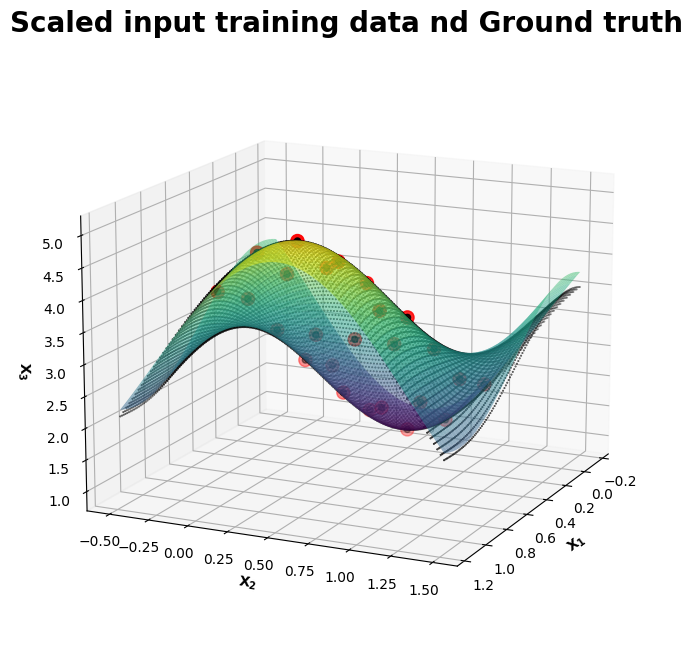

In [81]:
#Plotting the scaled input
fig = plt.figure(figsize=(16,8))
axs = fig.add_subplot(111,projection="3d")

axs.set_title("Scaled input training data nd Ground truth", fontsize=20, fontweight="bold")
axs.set_xlabel("$\mathbf{X_1}$",fontweight=12)
axs.set_ylabel("$\mathbf{X_2}$",fontweight=12)
axs.set_zlabel("$\mathbf{X_3}$", fontweight=12)

ground_truth_scaled = axs.plot_surface(x1_scaled,x2_scaled,x3,cmap="viridis",alpha=0.5)
gpr_mean_predict = axs.scatter(x_test_scaled[:,0],x_test_scaled[:,1],x3_gpr,c="k",s=0.2)

gpr_mean_predict2 = axs.scatter(x_scaled_train[:,0],x_scaled_train[:,1],x3_gpr_2,c="r",s=90)
scaled_training = axs.scatter(x_scaled_train[:,0],x_scaled_train[:,1],x3_train,c="k")


axs.view_init(elev=15, azim=25)
plt.show()

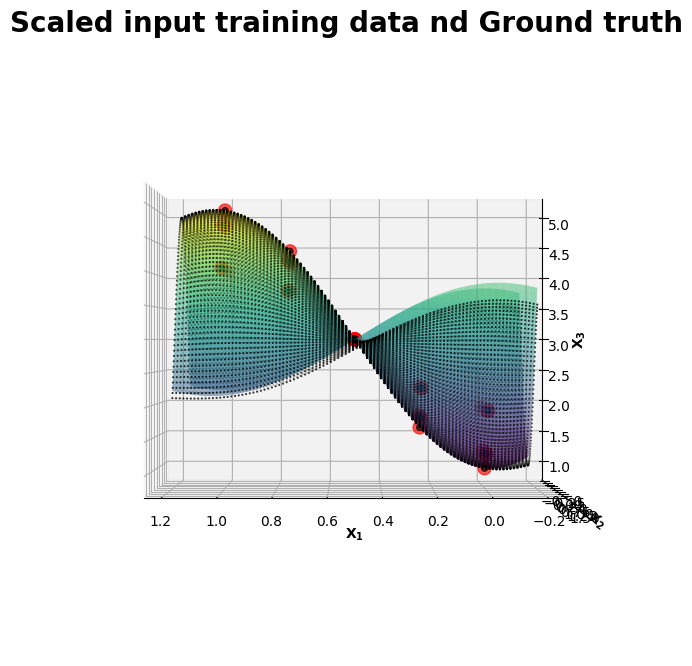

In [82]:
#Plotting the scaled input
fig = plt.figure(figsize=(16,8))
axs = fig.add_subplot(111,projection="3d")

axs.set_title("Scaled input training data nd Ground truth", fontsize=20, fontweight="bold")
axs.set_xlabel("$\mathbf{X_1}$",fontweight=12)
axs.set_ylabel("$\mathbf{X_2}$",fontweight=12)
axs.set_zlabel("$\mathbf{X_3}$", fontweight=12)

ground_truth_scaled = axs.plot_surface(x1_scaled,x2_scaled,x3,cmap="viridis",alpha=0.5)
gpr_mean_predict = axs.scatter(x_test_scaled[:,0],x_test_scaled[:,1],x3_gpr,c="k",s=0.2)

gpr_mean_predict2 = axs.scatter(x_scaled_train[:,0],x_scaled_train[:,1],x3_gpr_2,c="r",s=90)
scaled_training = axs.scatter(x_scaled_train[:,0],x_scaled_train[:,1],x3_train,c="k")


axs.view_init(elev=0, azim=90)
plt.show()